# Collaborative Filtering Recommendation System
* Building a Product Recommendation Engine
* Import Libraries and Setup

In [21]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
from surprise import Dataset, Reader, SVD, KNNBasic, KNNWithZScore, NormalPredictor
from surprise.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_validate
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
import random

## Data Loading and Initial Exploration
* This section loads the data and performs initial checks on the dataset.

In [2]:
# Define the data loading function
def load_data():
    project_root = os.getcwd()
    datasets = os.path.join(project_root, "datasets/")
    
    # Define the dtype for both author_id and product_id to avoid mixed types
    dtype_dict = {
        'author_id': str,
        'product_id': str
    }
    
    # Load product info and reviews
    product_info = pd.read_csv(os.path.join(datasets, "product_info.csv"), dtype=dtype_dict)
    reviews_files = [
        "reviews_0-250.csv", "reviews_250-500.csv", 
        "reviews_500-750.csv", "reviews_750-1250.csv", 
        "reviews_1250-end.csv"
    ]
    
    all_reviews = []
    for file in reviews_files:
        reviews = pd.read_csv(os.path.join(datasets, file), dtype=dtype_dict)
        all_reviews.append(reviews)
    
    # Concatenate all reviews and remove duplicates
    all_reviews = pd.concat(all_reviews, ignore_index=True).drop_duplicates()
    
    return product_info, all_reviews

# Load the data
product_info, all_reviews = load_data()

# Display basic information about the datasets
print("Product Info Shape:", product_info.shape)
print("All Reviews Shape:", all_reviews.shape)

# Display sample of product info
display(product_info.head())
display(all_reviews.head())

Product Info Shape: (8494, 27)
All Reviews Shape: (1094411, 19)


,product_id,product_name,brand_id,brand_name,loves_count,rating,reviews,size,variation_type,variation_value,...,online_only,out_of_stock,sephora_exclusive,highlights,primary_category,secondary_category,tertiary_category,child_count,child_max_price,child_min_price
0,P473671,Fragrance Discovery Set,6342,19-69,6320,3.6364,11.0,NaN,NaN,NaN,...,1,0,0,"['Unisex/ Genderless Scent', 'Warm &Spicy Scen...",Fragrance,Value & Gift Sets,Perfume Gift Sets,0,NaN,NaN
1,P473668,La Habana Eau de Parfum,6342,19-69,3827,4.1538,13.0,3.4 oz/ 100 mL,Size + Concentration + Formulation,3.4 oz/ 100 mL,...,1,0,0,"['Unisex/ Genderless Scent', 'Layerable Scent'...",Fragrance,Women,Perfume,2,85.0,30.0
2,P473662,Rainbow Bar Eau de Parfum,6342,19-69,3253,4.2500,16.0,3.4 oz/ 100 mL,Size + Concentration + Formulation,3.4 oz/ 100 mL,...,1,0,0,"['Unisex/ Genderless Scent', 'Layerable Scent'...",Fragrance,Women,Perfume,2,75.0,30.0
3,P473660,Kasbah Eau de Parfum,6342,19-69,3018,4.4762,21.0,3.4 oz/ 100 mL,Size + Concentration + Formulation,3.4 oz/ 100 mL,...,1,0,0,"['Unisex/ Genderless Scent', 'Layerable Scent'...",Fragrance,Women,Perfume,2,75.0,30.0
4,P473658,Purple Haze Eau de Parfum,6342,19-69,2691,3.2308,13.0,3.4 oz/ 100 mL,Size + Concentration + Formulation,3.4 oz/ 100 mL,...,1,0,0,"['Unisex/ Genderless Scent', 'Layerable Scent'...",Fragrance,Women,Perfume,2,75.0,30.0


,Unnamed: 0,author_id,rating,is_recommended,helpfulness,total_feedback_count,total_neg_feedback_count,total_pos_feedback_count,submission_time,review_text,review_title,skin_tone,eye_color,skin_type,hair_color,product_id,product_name,brand_name,price_usd
0,0,1741593524,5,1.0,1.0,2,0,2,2023-02-01,I use this with the Nudestix “Citrus Clean Bal...,Taught me how to double cleanse!,NaN,brown,dry,black,P504322,Gentle Hydra-Gel Face Cleanser,NUDESTIX,19.0
1,1,31423088263,1,0.0,NaN,0,0,0,2023-03-21,I bought this lip mask after reading the revie...,Disappointed,NaN,NaN,NaN,NaN,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0
2,2,5061282401,5,1.0,NaN,0,0,0,2023-03-21,My review title says it all! I get so excited ...,New Favorite Routine,light,brown,dry,blonde,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0
3,3,6083038851,5,1.0,NaN,0,0,0,2023-03-20,I’ve always loved this formula for a long time...,Can't go wrong with any of them,NaN,brown,combination,black,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0
4,4,47056667835,5,1.0,NaN,0,0,0,2023-03-20,"If you have dry cracked lips, this is a must h...",A must have !!!,light,hazel,combination,NaN,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0


## Data Preprocessing
* This section handles missing values and prepares the data for model training.

In [3]:
def preprocess_data(product_info, all_reviews):
    # Merge product info with reviews
    merged_df = all_reviews.merge(
        product_info[['product_id', 'product_name', 'brand_name']], 
        on='product_id', 
        how='left'
    )
    
    # Check for missing values
    print("Missing values:")
    print(merged_df.isnull().sum())
    
    # Create mapping dictionaries for users and items
    user_mapper = {id_: idx for idx, id_ in enumerate(merged_df['author_id'].unique())}
    item_mapper = {id_: idx for idx, id_ in enumerate(merged_df['product_id'].unique())}
    
    # Create reverse mappers
    reverse_user_mapper = {v: k for k, v in user_mapper.items()}
    reverse_item_mapper = {v: k for k, v in item_mapper.items()}
    
    # Transform IDs to numerical indices
    merged_df['user_idx'] = merged_df['author_id'].map(user_mapper)
    merged_df['item_idx'] = merged_df['product_id'].map(item_mapper)
    
    return merged_df, user_mapper, item_mapper, reverse_user_mapper, reverse_item_mapper

# Preprocess the data
merged_df, user_mapper, item_mapper, reverse_user_mapper, reverse_item_mapper = preprocess_data(product_info, all_reviews)

Missing values:
Unnamed: 0                       0
author_id                        0
rating                           0
is_recommended              167988
helpfulness                 561592
total_feedback_count             0
total_neg_feedback_count         0
total_pos_feedback_count         0
submission_time                  0
review_text                   1444
review_title                310654
skin_tone                   170539
eye_color                   209628
skin_type                   111557
hair_color                  226768
product_id                       0
product_name_x                   0
brand_name_x                     0
price_usd                        0
product_name_y                   0
brand_name_y                     0
dtype: int64


In [4]:
merged_df.head(5)

,Unnamed: 0,author_id,rating,is_recommended,helpfulness,total_feedback_count,total_neg_feedback_count,total_pos_feedback_count,submission_time,review_text,...,skin_type,hair_color,product_id,product_name_x,brand_name_x,price_usd,product_name_y,brand_name_y,user_idx,item_idx
0,0,1741593524,5,1.0,1.0,2,0,2,2023-02-01,I use this with the Nudestix “Citrus Clean Bal...,...,dry,black,P504322,Gentle Hydra-Gel Face Cleanser,NUDESTIX,19.0,Gentle Hydra-Gel Face Cleanser,NUDESTIX,0,0
1,1,31423088263,1,0.0,NaN,0,0,0,2023-03-21,I bought this lip mask after reading the revie...,...,NaN,NaN,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,1,1
2,2,5061282401,5,1.0,NaN,0,0,0,2023-03-21,My review title says it all! I get so excited ...,...,dry,blonde,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,2,1
3,3,6083038851,5,1.0,NaN,0,0,0,2023-03-20,I’ve always loved this formula for a long time...,...,combination,black,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,3,1
4,4,47056667835,5,1.0,NaN,0,0,0,2023-03-20,"If you have dry cracked lips, this is a must h...",...,combination,NaN,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,4,1


To prepare the data for the Surprise library, we preprocessed the data by merging product information with user reviews. All rows from all_reviews are retained, even if there is no matching product in product_info. Thankfully all the reviews contained relevant product_info such as the product_id and brand_name. We have also transformed user and product IDs into numerical indices, making it easier to feed the data into algorithms. Thus creating new variables: 'user_idx' and 'item_idx'.

## Exploratory Data Analysis (EDA)
* This section visualizes key aspects of the dataset to gain insights.

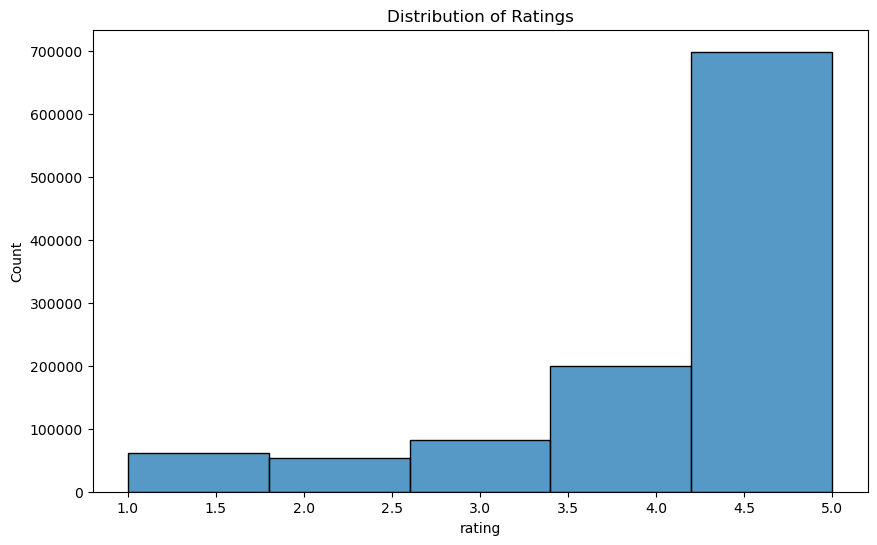


Rating Statistics:
count    1.094411e+06
mean     4.299158e+00
std      1.149444e+00
min      1.000000e+00
25%      4.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: rating, dtype: float64


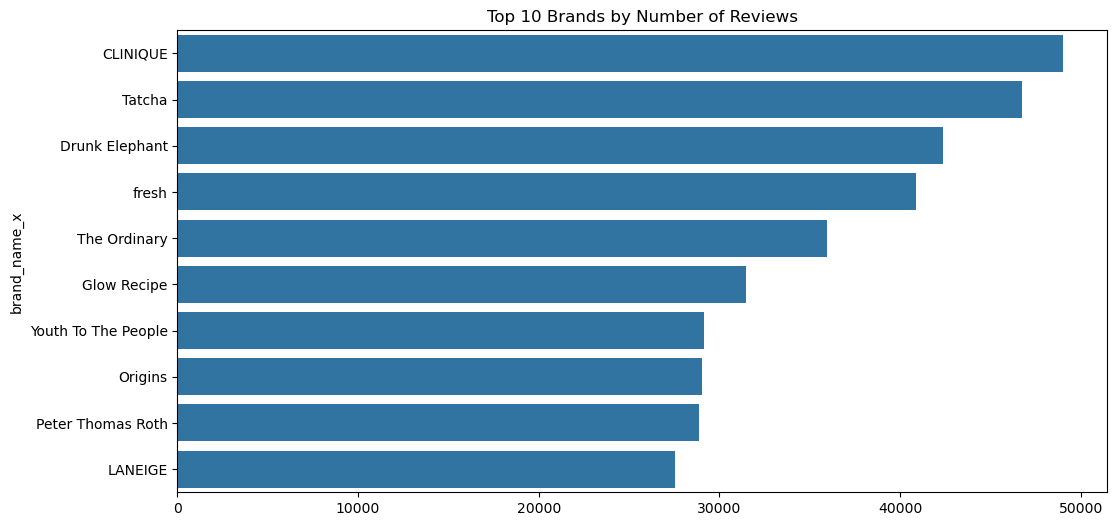

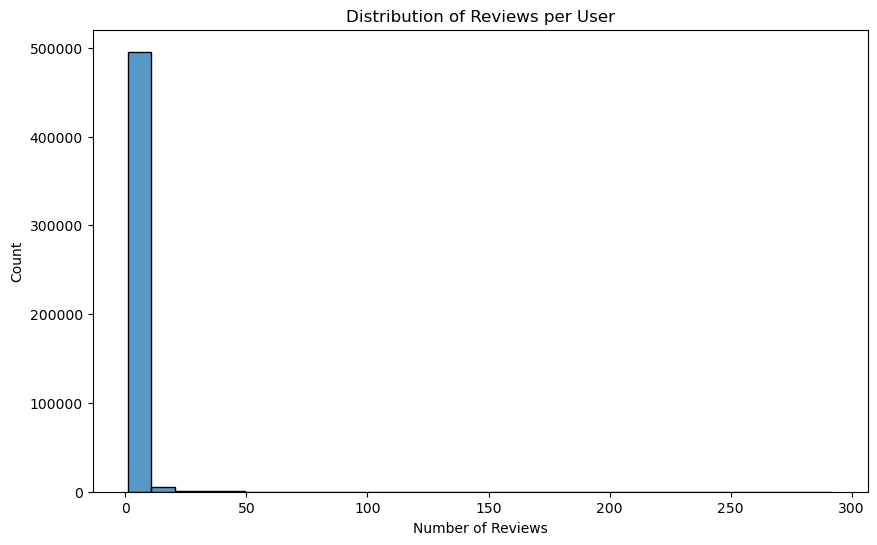


User Activity Statistics:
count    503216.000000
mean          2.174833
std           3.414628
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         292.000000
dtype: float64


In [5]:
def perform_eda(merged_df):
    # 1. Rating Distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(merged_df['rating'], bins=5)
    plt.title('Distribution of Ratings')
    plt.show()
    
    print("\nRating Statistics:")
    print(merged_df['rating'].describe())
    
    # 2. Top Brands
    plt.figure(figsize=(12, 6))
    top_brands = merged_df['brand_name_x'].value_counts().head(10)
    sns.barplot(x=top_brands.values, y=top_brands.index)
    plt.title('Top 10 Brands by Number of Reviews')
    plt.show()
    
    # 3. User Activity Analysis
    user_activity = merged_df.groupby('author_id').size()
    plt.figure(figsize=(10, 6))
    sns.histplot(user_activity, bins=30)
    plt.title('Distribution of Reviews per User')
    plt.xlabel('Number of Reviews')
    plt.show()
    
    print("\nUser Activity Statistics:")
    print(user_activity.describe())

# Perform EDA
perform_eda(merged_df)

Use the Reader class in the Surprise library for parsing and reading the rating data. I have indicated that the ratings can range from 1 to 5. This helps in training algorithms and validating predictions.

A subset is created from the `merged_df` dataset, containing user-item interactions and their ratings. This subset is then loaded into a format that the Surprise library can understand for training recommendation models. The `data` variable is defined as a Surprise Dataset object that can be used with various algorithms for collaborative filtering, matrix factorization, or other recommendation techniques.

In [6]:
# Prepare data for Surprise library
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(merged_df[['user_idx', 'item_idx', 'rating']], reader)

## Model Training and Evaluation
* This section prepares the data for the Surprise library and trains multiple models to create a similarity matrix.
* These models compute similarities between items or users, similar to collaborative filtering. Each model instance will be implemented with varying hyperparameters.

In [17]:
def train_and_evaluate_models(merged_df):
    # Prepare data for Surprise
    reader = Reader(rating_scale=(1, 5))
    data = Dataset.load_from_df(merged_df[['user_idx', 'item_idx', 'rating']], reader)
    
    # Split into training and test set
    trainset, testset = surprise_train_test_split(data, test_size=0.25, random_state=42)
    
    # Initialize models
    models = {
        'SVD': SVD(n_factors=100, n_epochs=20, lr_all=0.005, reg_all=0.02),
        'KNNWithZScore': KNNWithZScore(sim_options={'name': 'pearson_baseline', 'user_based': False}, k=40),
        'KNNBasic': KNNBasic(sim_options={'name': 'cosine', 'user_based': False}, k=30),
        'NormalPredictor': NormalPredictor()
    }
    
    # Train and evaluate each model
    results = {}
    for name, model in models.items():
        print(f"\nTraining {name}...")
        model.fit(trainset)
        predictions = model.test(testset)
        results[name] = predictions
    
    return results, trainset, testset, models

# Train and evaluate models
results, trainset, testset, models = train_and_evaluate_models(merged_df)


Training SVD...

Training KNNWithZScore...
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.

Training KNNBasic...
Computing the cosine similarity matrix...
Done computing similarity matrix.

Training NormalPredictor...


After training the model, it predicts the rating a user would give to a specific item on a scale from 1 to 5, based on their past behavior and the behavior of similar users or items. In this case, the user has actually rated the item 5.0, and the prediction was made successfully without any issues.

In some cases, the model attempts to predict how a user would rate an item based on available data. However, it could not geberate a reliable prediction becauser it did not have sufficient information about the user and/or the item in its training data.

In [31]:
# Display the first 5 predictions generated
first_five_predictions = results['SVD'][:5]

data = [{
    'user_id': pred.uid,
    'item_id': pred.iid,
    'actual_rating': pred.r_ui,
    'estimated_rating': pred.est
} for pred in first_five_predictions]

# Create a DataFrame
df_predictions = pd.DataFrame(data)
df_predictions

,user_id,item_id,actual_rating,estimated_rating
0,62051,9,5.0,4.943412
1,60554,144,5.0,4.532397
2,423488,547,5.0,4.555726
3,186131,61,1.0,3.480204
4,235961,783,5.0,4.874563


For example, User 62051 gave item #9 a rating of 5.0, while the SVD model predicted a rating of 4.94.

However, the model is off by a bit when predicting User 186131. The User actually gave a 1.0 when the model predicted 3.48 Now let's see if hyperparameter tuning can improve the accuracy of the recommendation model.

## Model Comparison and Hyperparameter Tuning
* This section compares different models and performs hyperparameter tuning for the best model.

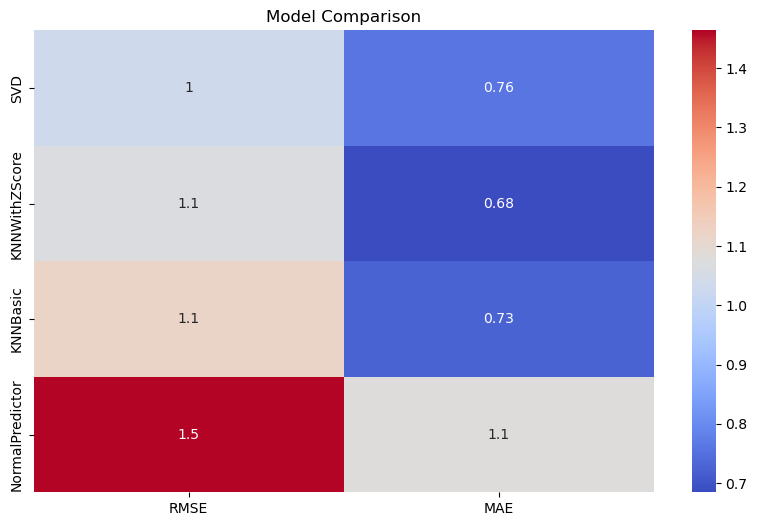

Best parameters: {'n_factors': 50, 'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}
Best RMSE: 1.0948451244420425


In [14]:
def compare_models(results):
    model_metrics = {}
    for name, predictions in results.items():
        rmse = np.sqrt(np.mean([(p.r_ui - p.est)**2 for p in predictions]))
        mae = np.mean([abs(p.r_ui - p.est) for p in predictions])
        model_metrics[name] = {'RMSE': rmse, 'MAE': mae}
    
    metrics_df = pd.DataFrame(model_metrics).T
    
    plt.figure(figsize=(10, 6))
    sns.heatmap(metrics_df, annot=True, cmap='coolwarm')
    plt.title('Model Comparison')
    plt.show()
    
    return metrics_df

# Compare models
metrics_df = compare_models(results)

# Hyperparameter tuning for the best model
def tune_best_model(data):
    param_grid = {
        'n_factors': [50, 100],
        'n_epochs': [5, 10],
        'lr_all': [0.002, 0.005],
        'reg_all': [0.4, 0.6]
    }
    
    gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)
    gs.fit(data)
    
    print("Best parameters:", gs.best_params['rmse'])
    print("Best RMSE:", gs.best_score['rmse'])
    
    return gs.best_params['rmse']

# Tune the best model
best_params = tune_best_model(Dataset.load_from_df(merged_df[['user_idx', 'item_idx', 'rating']], Reader(rating_scale=(1, 5))))

## Generating Recommendations
* This section demonstrates how to generate and evaluate recommendations for users.

In [15]:
def get_top_n_recommendations(predictions, n=5):
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))
    
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
    
    return top_n

def display_recommendations(top_n, reverse_user_mapper, reverse_item_mapper, product_info):
    for user_idx, user_ratings in list(top_n.items())[:3]:
        original_user_id = reverse_user_mapper[user_idx]
        print(f"\nRecommendations for User {original_user_id}:")
        for item_idx, est in user_ratings:
            original_item_id = reverse_item_mapper[item_idx]
            product_name = product_info[product_info['product_id'] == original_item_id]['product_name'].values[0]
            print(f"  {product_name} (predicted rating: {est:.2f})")

# Generate and display recommendations
best_model_predictions = results['SVD']  # or whichever model performed best
top_n_recommendations = get_top_n_recommendations(best_model_predictions, n=5)
display_recommendations(top_n_recommendations, reverse_user_mapper, reverse_item_mapper, product_info)


Recommendations for User 5967422089:
  Protini Polypeptide Firming Refillable Moisturizer (predicted rating: 3.87)

Recommendations for User 5477626830:
  Grape Water Moisturizing Face Mist (predicted rating: 4.30)

Recommendations for User 7134624510:
  Mini Rare Earth Deep Pore Minimizing Cleansing Clay Mask (predicted rating: 4.58)
  Rare Earth Deep Pore Minimizing Cleansing Clay Mask (predicted rating: 4.57)


#### Interactive Recommendation Generation
* This section allows for interactive testing of the recommendation system.

In [28]:
def get_recommendations_for_user(user_id, model, product_info, user_mapper, item_mapper, reverse_item_mapper):
    if user_id not in user_mapper:
        print(f"User ID {user_id} not found in the dataset.")
        return
    
    user_idx = user_mapper[user_id]
    predictions = []
    
    for item_id in product_info['product_id']:
        if item_id in item_mapper:
            item_idx = item_mapper[item_id]
            pred = model.predict(user_idx, item_idx)
            predictions.append((item_id, pred.est))
    
    predictions.sort(key=lambda x: x[1], reverse=True)
    
    print(f"\nTop 5 Recommendations for User {user_id}:")
    for item_id, est in predictions[:5]:
        product_name = product_info[product_info['product_id'] == item_id]['product_name'].values[0]
        print(f"  {product_name} (predicted rating: {est:.2f})")

# Test recommendation system
test_user_id = random.choice(list(user_mapper.keys()))  # Get a random user ID
get_recommendations_for_user(test_user_id, models['SVD'], product_info, user_mapper, item_mapper, reverse_item_mapper)


Top 5 Recommendations for User 6691826827:
  The Silk Peony Melting Eye Cream (predicted rating: 4.95)
  Glycolic Acid 7% Exfoliating Toning Solution (predicted rating: 4.93)
  Blue Aventurine De-Puffing Facial Roller (predicted rating: 4.93)
  Sound Sleep Cocoon Night Gel-Cream (predicted rating: 4.93)
  Future Solution LX Concentrated Balancing Softener (predicted rating: 4.93)


# Conclusion and Next Steps

In this notebook, we've built a collaborative filtering recommendation system using the Surprise library. We've covered:

* Data preprocessing and exploration
* Training multiple recommendation models
* Model evaluation and comparison
* Hyperparameter tuning
* Generating personalized recommendations

Potential next steps:

* Implement content-based features for hybrid recommendations
* Develop a more sophisticated evaluation framework
* Create a simple web interface for testing recommendations
* Explore techniques for handling cold-start problems